# My LEEDS 2023

Prepares data for the My LEEDS 2023 page 

In [1]:
from events import (
    load_event_data, filter_by_project, prepare, save_files, count_wards
)

Set output directory

In [2]:
OUT_DIR = '../../../../docs/metrics/events/my-leeds-2023/_data/events'

Read in event data and filter by **My LEEDS 2023** project

In [3]:
data = load_event_data().pipe(filter_by_project, '12 - My LEEDS 2023')

Run the processing and save the files

In [4]:
data = data.pipe(prepare).pipe(save_files, OUT_DIR)

Print a list of events which have no ward, or more than one

In [5]:
data[data.pipe(count_wards) != 1][[
    'airtable_id',
    'event_name',
    'start_date',
    'ward_(from_venue)',
]]

,airtable_id,event_name,start_date,ward_(from_venue)
768,657,The Gift: Garments,2023-06-17,NaN
770,656,The Gift: digital gift launch,2023-06-19,NaN
828,265,My Leeds Event Day 1 (Live Activation),2023-07-08,NaN
830,430,My LEEDS Summer: Alwoodley Festival of Sport a...,2023-07-09,"['Alwoodley', 'Alwoodley', 'Alwoodley', 'Alwoo..."


Print a list of events with no audience recorded

In [6]:
data[data.audience_size == 0][[
    'airtable_id', 'event_name', 'start_date', 'audience_size'
]]

,airtable_id,event_name,start_date,audience_size
265,560,Pudsey Grant Info Session,2023-02-13,0.0
266,561,Rothwell Grant Info Session,2023-02-13,0.0
268,562,Roundhay Grant Info Session 1,2023-02-13,0.0
280,567,Wetherby Grant Info Session 1,2023-02-14,0.0
289,565,Weetwood Grant Info Session 1,2023-02-15,0.0
300,563,Roundhay Grant Info Session 2,2023-02-16,0.0
303,564,Temple Newsam Grant Info Session,2023-02-16,0.0
315,566,Weetwood Grant Info Session 2,2023-02-19,0.0
323,558,Otley and Yeadon Grant Info Session 1,2023-02-20,0.0
334,559,Otley and Yeadon Grant Info Session 2,2023-02-21,0.0


event_type
['Public Event - Digital Experience']     1
['Public Event - Installation']           1
['Public Event - Performance']           25
['Public Event - Talk / Tour']           11
Name: event_name, dtype: int64

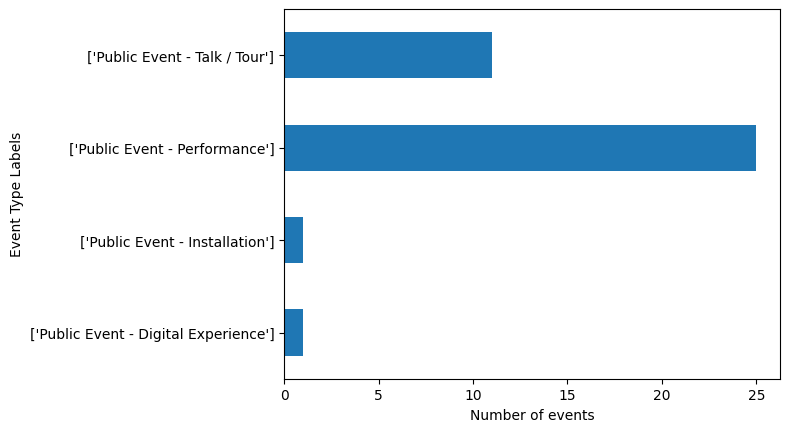

In [7]:
plot = data.groupby('event_type').event_name.count().plot.barh()
plot.xaxis.label.set_text('Number of events')
plot.yaxis.label.set_text('Event Type Labels')
data.groupby('event_type').event_name.count()